In [19]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from eval import Eval

In [2]:
base_model_version = "v8.0"
model_version = "v8.2"

In [3]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [4]:
with open('data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [5]:
df = pd.read_csv(f"data/processed/photometry_only.csv")

X = df[photo_cols + generic_cols]
y = df[target_col]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
input_shape = X_train_scaled.shape[1]

inputs = keras.Input(shape=(input_shape,))

x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_32')(inputs)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_64')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_128')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_256')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_32.2')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.load_weights(f'models/{base_model_version}/spec_photo_model.h5', by_name=True, skip_mismatch=True)

model.get_layer('Dense_32').trainable = False
model.get_layer('Dense_64').trainable = False
model.get_layer('Dense_128').trainable = True
model.get_layer('Dense_256').trainable = True
model.get_layer('Dense_32.2').trainable = True

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', 'mape'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39)]              0         
                                                                 
 Dense_32 (Dense)            (None, 32)                1280      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 Dense_64 (Dense)            (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

In [9]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.4, verbose=1, callbacks=[early_stopping])

Epoch 1/200
3351/3351 [==============================] - 29s 8ms/step - loss: 7.2949 - mae: 2.0531 - mse: 6.8550 - mape: 19.4243 - val_loss: 1.1021 - val_mae: 0.7011 - val_mse: 0.6842 - val_mape: 6.5478
Epoch 2/200
3351/3351 [==============================] - 46s 14ms/step - loss: 3.9648 - mae: 1.5017 - mse: 3.5713 - mape: 14.2343 - val_loss: 0.9009 - val_mae: 0.5958 - val_mse: 0.5262 - val_mape: 5.6335
Epoch 3/200
3351/3351 [==============================] - 48s 14ms/step - loss: 2.1983 - mae: 1.0702 - mse: 1.8261 - mape: 10.1777 - val_loss: 0.8005 - val_mae: 0.5172 - val_mse: 0.4365 - val_mape: 4.9853
Epoch 4/200
3351/3351 [==============================] - 47s 14ms/step - loss: 1.3685 - mae: 0.7914 - mse: 1.0111 - mape: 7.5723 - val_loss: 0.7979 - val_mae: 0.5224 - val_mse: 0.4430 - val_mape: 5.0357
Epoch 5/200
3351/3351 [==============================] - 48s 14ms/step - loss: 0.9706 - mae: 0.6119 - mse: 0.6166 - mape: 5.9004 - val_loss: 0.7861 - val_mae: 0.5080 - val_mse: 0.4319 - 

In [12]:
y_pred = model.predict(X_test_scaled)

1396/1396 [==============================] - 4s 3ms/step


In [20]:
Eval.plot_metrics(y_test, y_pred)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.4996
Root Mean Squared Error (RMSE): 0.6599
R² Score: -0.0000


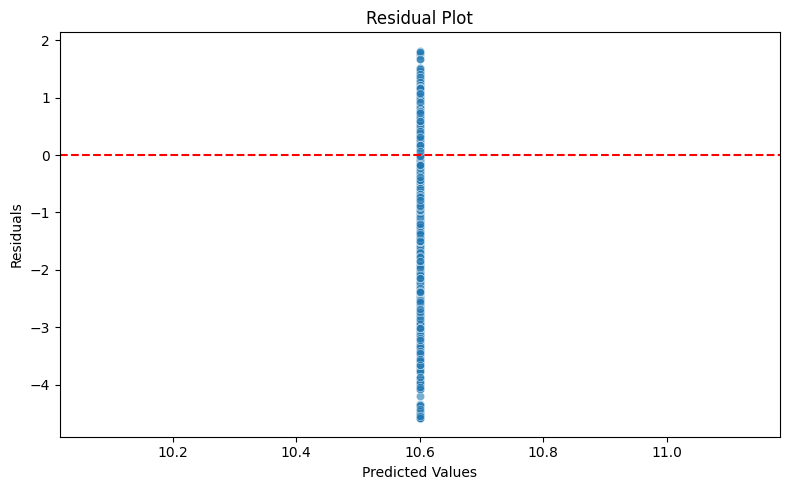

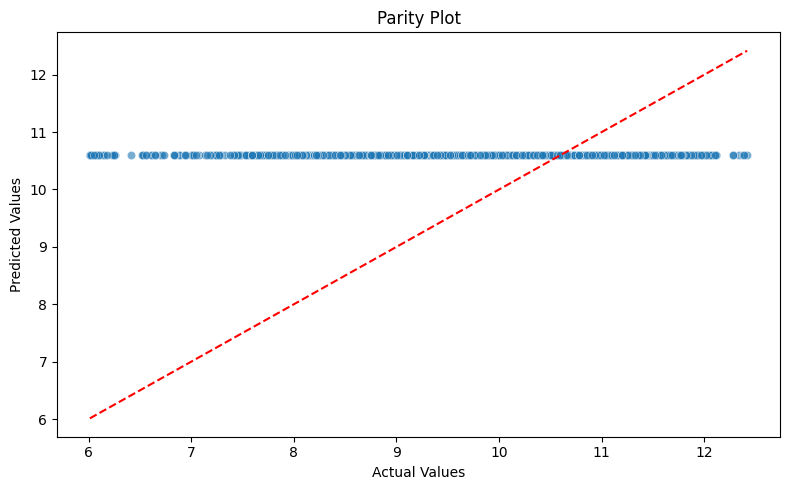

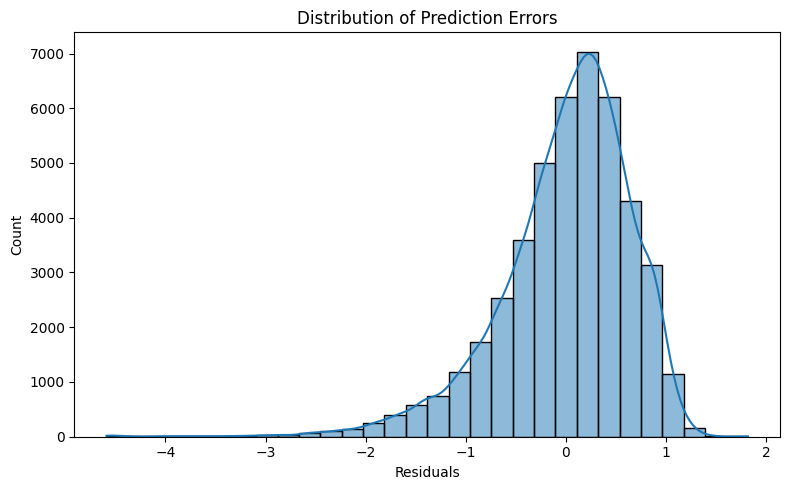

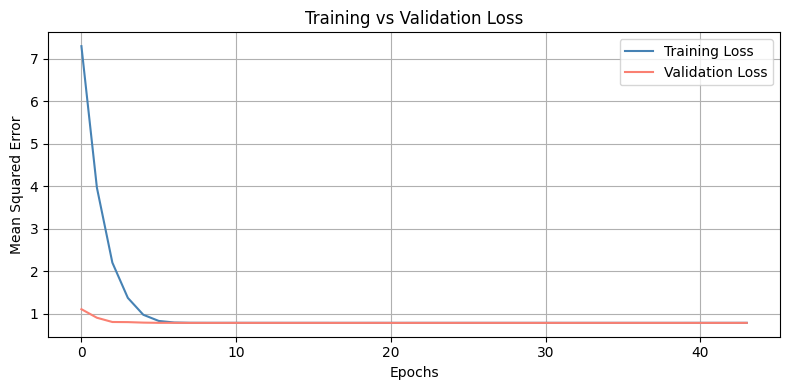

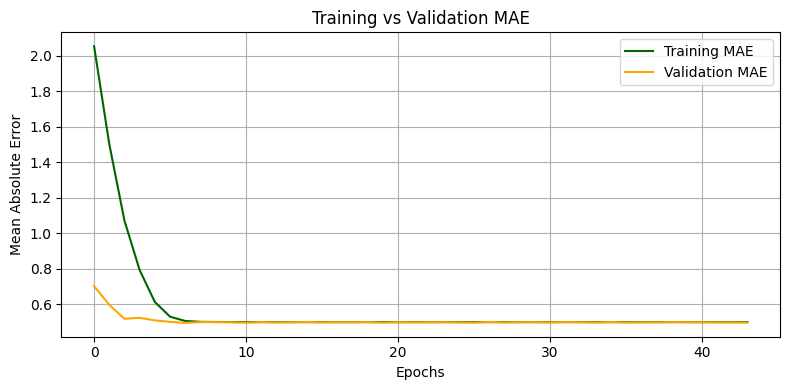

In [21]:
Eval.plot_visualizations(history, y_test, y_pred)